In [62]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [63]:
df = pd.read_csv("fake_job_postings.csv", index_col="job_id")
df.shape

(17880, 17)

## Edit Data

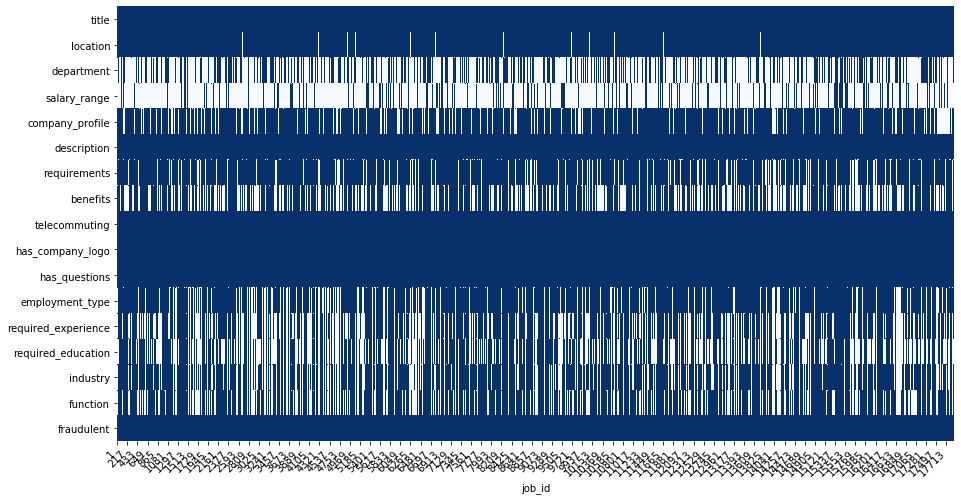

In [64]:
plot_missing_value(df)

In [65]:
df.drop(columns="department", inplace=True)
df.drop(columns="salary_range", inplace=True)
df.shape

(17880, 15)

In [66]:
df.dropna(subset=['location'], inplace=True)

In [67]:
df.shape

(17534, 15)

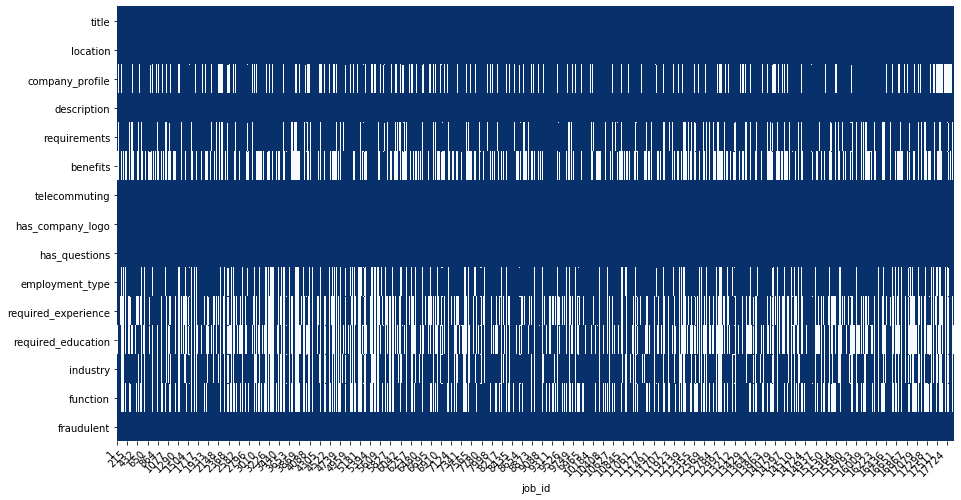

In [68]:
plot_missing_value(df)

In [69]:
df.location = df.location.apply(lambda x: x.split(sep=',')[0])

In [80]:
df.location.unique()

array(['US', 'NZ', 'DE', 'GB', 'AU', 'SG', 'IL', 'AE', 'CA', 'IN', 'EG',
       'PL', 'GR', 'PK', 'BE', 'BR', 'SA', 'DK', 'RU', 'ZA', 'CY', 'HK',
       'TR', 'IE', 'LT', 'JP', 'NL', 'AT', 'KR', 'FR', 'EE', 'TH', 'PA',
       'KE', 'MU', 'MX', 'RO', 'MY', 'FI', 'CN', 'ES', 'SE', 'CL', 'UA',
       'QA', 'IT', 'LV', 'IQ', 'BG', 'PH', 'CZ', 'VI', 'MT', 'HU', 'BD',
       'KW', 'LU', 'NG', 'RS', 'BY', 'VN', 'ID', 'ZM', 'NO', 'BH', 'UG',
       'CH', 'TT', 'SD', 'SK', 'AR', 'TW', 'PT', 'PE', 'CO', 'IS', 'SI',
       'MA', 'AM', 'TN', 'GH', 'AL', 'HR', 'CM', 'SV', 'NI', 'LK', 'JM',
       'KZ', 'KH'], dtype=object)

In [81]:
df.head()

title location  \
job_id                                                       
1                                Marketing Intern       US   
2       Customer Service - Cloud Video Production       NZ   
3         Commissioning Machinery Assistant (CMA)       US   
4               Account Executive - Washington DC       US   
5                             Bill Review Manager       US   

                                          company_profile  \
job_id                                                      
1       We're Food52, and we've created a groundbreaki...   
2       90 Seconds, the worlds Cloud Video Production ...   
3       Valor Services provides Workforce Solutions th...   
4       Our passion for improving quality of life thro...   
5       SpotSource Solutions LLC is a Global Human Cap...   

                                              description  \
job_id                                                      
1       Food52, a fast-growing, James Beard Award-winn...   
2       Organised - Focused - Vibrant - Awesome!Do you...   
3       Our client, located in Houston, is actively se...   
4       THE COMPANY: ESRI – Environmental Systems Rese...   
5       JOB TITLE: Itemization Review ManagerLOCATION:...   

                                             requirements  \
job_id                                                      
1       Experience with content management systems a m...   
2       What we expect from you:Your key responsibilit...   
3       Implement pre-commissioning and commissioning ...   
4       EDUCATION: Bachelor’s or Master’s in GIS, busi...   
5       QUALIFICATIONS:RN license in the State of Texa...   

                                                 benefits  telecommuting  \
job_id                                                                     
1                                                     NaN              0   
2       What you will get from usThrough being part of...              0   
3                                                     NaN              0   
4       Our culture is anything but corporate—we have ...              0   
5                                   Full Benefits Offered              0   

        has_company_logo  has_questions employment_type required_experience  \
job_id                                                                        
1                      1              0           Other          Internship   
2                      1              0       Full-time      Not Applicable   
3                      1              0             NaN                 NaN   
4                      1              0       Full-time    Mid-Senior level   
5                      1              1       Full-time    Mid-Senior level   

       required_education                   industry              function  \
job_id                                                                       
1                     NaN                        NaN             Marketing   
2                     NaN  Marketing and Advertising      Customer Service   
3                     NaN                        NaN                   NaN   
4       Bachelor's Degree          Computer Software                 Sales   
5       Bachelor's Degree     Hospital & Health Care  Health Care Provider   

        fraudulent  
job_id              
1                0  
2                0  
3                0  
4                0  
5                0

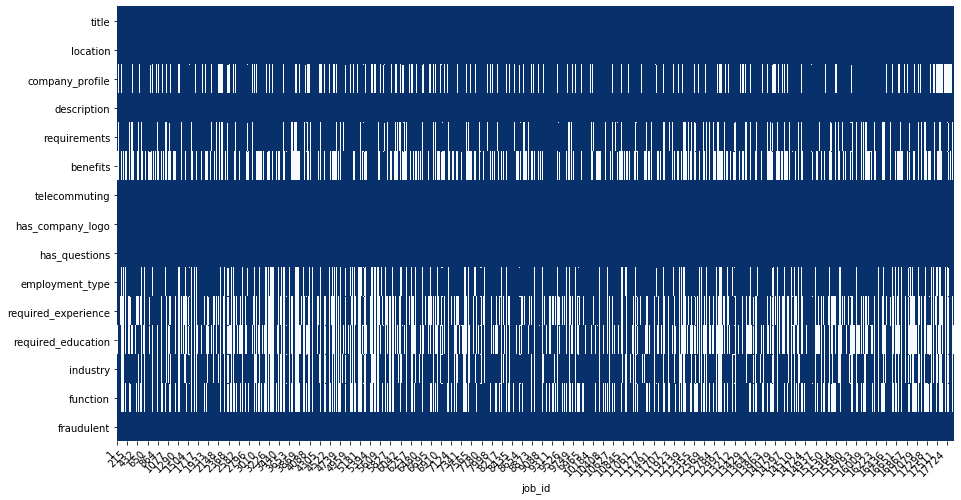

In [104]:
plot_missing_value(df)

## Pipeline for word

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.impute import SimpleImputer

In [83]:
class RavelTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.ravel()

text_pipe_x = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ])
text_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('ravel', RavelTransformer()),
    ('countvectorizer', CountVectorizer(analyzer='word', tokenizer=None, preprocessor=None, stop_words='english', 
        max_features=100)),
    ('tfidf', TfidfTransformer()),])

In [84]:
X = df.drop(columns="fraudulent")
y = df.fraudulent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7013, 14), (10521, 14), (7013,), (10521,))

## SVM

In [86]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [87]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), []),
    ('categoric', cat_pipe(encoder='onehot'), ['location', 'telecommuting', 'has_company_logo', 'has_questions',
                                               'employment_type', 'required_experience', 'required_education',
                                               'industry', 'function']),
    ('title', text_pipe,['title']),
    ('company', text_pipe,['company_profile']),
    ('description', text_pipe,['description']),
    ('requirement', text_pipe,['requirements']),
    ('benefits', text_pipe,['benefits'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])


model_1 = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_1.fit(X_train, y_train)

print(model_1.best_params_)
print(model_1.score(X_train, y_train), model_1.best_score_, model_1.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  8.9min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9970414201183432 0.7853039653827055 0.825749167591565


feature  importance     stdev
0                 title    0.046541  0.002820
12             industry    0.036846  0.004652
2       company_profile    0.030900  0.002479
3           description    0.025389  0.006234
7      has_company_logo    0.016824  0.001084
4          requirements    0.009256  0.002389
13             function    0.008655  0.003221
5              benefits    0.007753  0.002901
9       employment_type    0.006254  0.001112
1              location    0.005362  0.002027
11   required_education    0.003276  0.001117
8         has_questions    0.001186  0.000593
10  required_experience    0.000894  0.001788
6         telecommuting    0.000297  0.000594

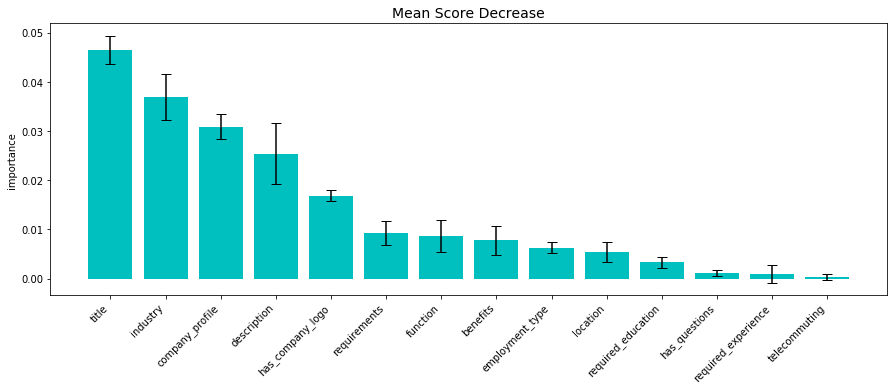

In [88]:
mean_score_decrease(X_train, y_train, model_1, plot=True)

In [106]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), []),
    ('categoric', cat_pipe(encoder='onehot'), ['location', 'telecommuting', 'has_company_logo', 'has_questions',
                                               'employment_type', 'required_experience', 'required_education',
                                               'industry', 'function']),
    ('title', text_pipe,['title']),
    ('company', text_pipe,['company_profile']),
    ('description', text_pipe,['description']),
    ('requirement', text_pipe,['requirements']),
    ('benefits', text_pipe,['benefits'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])


model_1 = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_1.fit(X_train, y_train)

print(model_1.best_params_)
print(model_1.score(X_train, y_train), model_1.best_score_, model_1.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  8.7min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9940652818991098 0.7556932020477535 0.7956284153005463


## XGBoost

In [101]:
from xgboost import XGBClassifier
from jcopml.tuning.skopt import BayesSearchCV
from jcopml.tuning import bayes_search_params as bsp

from sklearn.ensemble import RandomForestClassifier


In [100]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), []),
    ('categoric', cat_pipe(encoder='onehot'), ['location', 'has_company_logo',
                                               'employment_type', 'required_education',
                                               'industry', 'function']),
    ('title', text_pipe,['title']),
    ('company', text_pipe,['company_profile']),
    ('description', text_pipe,['description']),
    ('requirement', text_pipe,['requirements']),
    ('benefits', text_pipe,['benefits'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])


model_XGBoost = BayesSearchCV(pipeline, bsp.xgb_params, cv=5, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGBoost.fit(X_train, y_train)

print(model_XGBoost.best_params_)
print(model_XGBoost.score(X_train, y_train), model_XGBoost.best_score_, model_XGBoost.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.5s finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


{'algo__colsample_bytree': 1.0, 'algo__gamma': 2, 'algo__learning_rate': 0.07922029399927968, 'algo__max_depth': 10, 'algo__n_estimators': 200, 'algo__reg_alpha': 0.04927344582991186, 'algo__reg_lambda': 0.001, 'algo__subsample': 0.8}


/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


0.9850299401197605 0.7656069052040874 0.7668639053254438


## RandomForest

In [103]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), []),
    ('categoric', cat_pipe(encoder='onehot'), ['location', 'has_company_logo',
                                               'employment_type', 'required_education',
                                               'industry', 'function']),
    ('title', text_pipe,['title']),
    ('company', text_pipe,['company_profile']),
    ('description', text_pipe,['description']),
    ('requirement', text_pipe,['requirements']),
    ('benefits', text_pipe,['benefits'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_XGBoost = BayesSearchCV(pipeline, bsp.rf_params, cv=5, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGBoost.fit(X_train, y_train)

print(model_XGBoost.best_params_)
print(model_XGBoost.score(X_train, y_train), model_XGBoost.best_score_, model_XGBoost.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.1s finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


{'algo__max_depth': 80, 'algo__max_features': 0.1, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 100}


/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


1.0 0.7415357399279735 0.7503015681544029


In [107]:
df.head()

title location  \
job_id                                                       
1                                Marketing Intern       US   
2       Customer Service - Cloud Video Production       NZ   
3         Commissioning Machinery Assistant (CMA)       US   
4               Account Executive - Washington DC       US   
5                             Bill Review Manager       US   

                                          company_profile  \
job_id                                                      
1       We're Food52, and we've created a groundbreaki...   
2       90 Seconds, the worlds Cloud Video Production ...   
3       Valor Services provides Workforce Solutions th...   
4       Our passion for improving quality of life thro...   
5       SpotSource Solutions LLC is a Global Human Cap...   

                                              description  \
job_id                                                      
1       Food52, a fast-growing, James Beard Award-winn...   
2       Organised - Focused - Vibrant - Awesome!Do you...   
3       Our client, located in Houston, is actively se...   
4       THE COMPANY: ESRI – Environmental Systems Rese...   
5       JOB TITLE: Itemization Review ManagerLOCATION:...   

                                             requirements  \
job_id                                                      
1       Experience with content management systems a m...   
2       What we expect from you:Your key responsibilit...   
3       Implement pre-commissioning and commissioning ...   
4       EDUCATION: Bachelor’s or Master’s in GIS, busi...   
5       QUALIFICATIONS:RN license in the State of Texa...   

                                                 benefits  telecommuting  \
job_id                                                                     
1                                                     NaN              0   
2       What you will get from usThrough being part of...              0   
3                                                     NaN              0   
4       Our culture is anything but corporate—we have ...              0   
5                                   Full Benefits Offered              0   

        has_company_logo  has_questions employment_type required_experience  \
job_id                                                                        
1                      1              0           Other          Internship   
2                      1              0       Full-time      Not Applicable   
3                      1              0             NaN                 NaN   
4                      1              0       Full-time    Mid-Senior level   
5                      1              1       Full-time    Mid-Senior level   

       required_education                   industry              function  \
job_id                                                                       
1                     NaN                        NaN             Marketing   
2                     NaN  Marketing and Advertising      Customer Service   
3                     NaN                        NaN                   NaN   
4       Bachelor's Degree          Computer Software                 Sales   
5       Bachelor's Degree     Hospital & Health Care  Health Care Provider   

        fraudulent  
job_id              
1                0  
2                0  
3                0  
4                0  
5                0

## MODIFY TEXT PIPE

In [108]:
class RavelTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.ravel()

text_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='EMPTY-FILL')),
    ('ravel', RavelTransformer()),
    ('countvectorizer', CountVectorizer(analyzer='word', tokenizer=None, preprocessor=None, stop_words='english', 
        max_features=100)),
    ('tfidf', TfidfTransformer()),])

In [109]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), []),
    ('categoric', cat_pipe(encoder='onehot'), ['location', 'telecommuting', 'has_company_logo', 'has_questions',
                                               'employment_type', 'required_experience', 'required_education',
                                               'industry', 'function']),
    ('title', text_pipe,['title']),
    ('company', text_pipe,['company_profile']),
    ('description', text_pipe,['description']),
    ('requirement', text_pipe,['requirements']),
    ('benefits', text_pipe,['benefits'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])


model_1 = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_1.fit(X_train, y_train)

print(model_1.best_params_)
print(model_1.score(X_train, y_train), model_1.best_score_, model_1.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 11.1min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9970414201183432 0.7853039653827055 0.825749167591565


## New Location

In [110]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [111]:
df = pd.read_csv("fake_job_postings.csv", index_col="job_id")
df.shape

(17880, 17)

In [112]:
df.drop(columns="department", inplace=True)
df.drop(columns="salary_range", inplace=True)
df.shape

(17880, 15)

AttributeError: 'float' object has no attribute 'split'